# PCA Analysis

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
plt.style.use('seaborn')

In [5]:
data_df = pd.read_csv('Data\\processed.csv')

# Preprocessing + PCA

In [6]:
# to_normalize = data_df[data_df.columns.difference(['KWH'])]
# kwh = data_df['KWH']
# data_df.drop(columns = 'KWH', inplace=True)

# # df_to_normalize = MinMaxScaler().fit_transform(to_normalize)
# df_to_normalize = Normalizer().fit_transform(to_normalize)
# df_to_normalize = pd.DataFrame(df_to_normalize)
# df_to_normalize.columns = data_df.columns

# data_df = pd.concat([df_to_normalize, kwh], axis = 1)

In [7]:
def plotVariance(X):
    pca = PCA(n_components=20)
    pca.fit(X)
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)')
    plt.title('Explained Variance')
    plt.show()

In [8]:
X = data_df[data_df.columns.difference(['KWH'])]
Y = data_df['KWH']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle = True, random_state = 42)

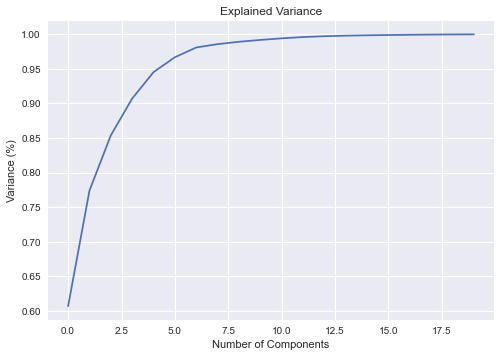

In [9]:
plotVariance(X_train)

In [10]:
PCA_train = PCA(n_components=10)
PCA_train.fit(X_train, Y_train)

X_train = PCA_train.transform(X_train)
X_test = PCA_train.transform(X_test)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(8456, 10) (8456,) (3625, 10) (3625,)


In [11]:
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(8456, 10) (8456,) (3625, 10) (3625,)


# Model Implementation

In [12]:
rr = Ridge(
    random_state=42,
    solver = 'auto'
)

rf = RandomForestRegressor(
    oob_score = True, 
    random_state = 42,
)

sgd = SGDRegressor( 
    random_state=42,
    penalty='l1', 
)

ls = Lasso(
    random_state = 42 
)

estimators = [rr, rf, sgd, ls]

In [13]:
param_rr = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]} 
param_rf = {'n_estimators': [5, 50, 100, 200, 500], 'max_depth': [1, 5, 10, 15], 'min_samples_leaf': [1, 5, 10]}
param_sgd = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'loss': ['squared_epsilon_insensitive', 'huber', 'epsilon_insensitive', 'squared_loss'], 'learning_rate': ['optimal', 'adaptive', 'invscaling']}
param_ls = {"selection": ["cyclic", "random"], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}

params = [param_rr, param_rf, param_sgd, param_ls]

In [14]:
def performingGridSearch(estimators, X_train, Y_train, X_test, Y_test, params):
    scores_train = []
    scores_test = []
 
    for index, estimator in enumerate(estimators):
        model = GridSearchCV(estimator, param_grid = params[index], cv = 3, n_jobs=-1, scoring='r2', verbose = 3)
        model.fit(X_train, Y_train)
        best_params = model.best_params_
        scores_train.append(model.score(X_train, Y_train))

        print("\n\n Model: {} \n\n Best params: {} ".format(estimator, best_params))
        scores_test.append(model.score(X_test, Y_test))

    return scores_train, scores_test

In [15]:
scores_train, scores_val = performingGridSearch(estimators, X_train, Y_train, X_test, Y_test, params)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


 Model: Ridge(random_state=42) 

 Best params: {'alpha': 0.0001} 
Fitting 3 folds for each of 60 candidates, totalling 180 fits


 Model: RandomForestRegressor(oob_score=True, random_state=42) 

 Best params: {'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 500} 
Fitting 3 folds for each of 60 candidates, totalling 180 fits


 Model: SGDRegressor(penalty='l1', random_state=42) 

 Best params: {'alpha': 0.001, 'learning_rate': 'adaptive', 'loss': 'squared_epsilon_insensitive'} 
Fitting 3 folds for each of 10 candidates, totalling 30 fits


 Model: Lasso(random_state=42) 

 Best params: {'alpha': 0.001, 'selection': 'cyclic'} 


In [17]:
estimators_names = ['Ridge', 'RandomForest', 'SGDRegressor', 'Lasso']
models_scores = pd.DataFrame([estimators_names, scores_train, scores_val], columns = None, index = ['Estimators', 'Scores Train', 'Scores Val'])
print(models_scores)

lr = LinearRegression()
rr = Ridge(
    random_state=42,
    solver = 'auto',
    alpha = 0.0001
)
rf = RandomForestRegressor(
    oob_score = True,  
    random_state = 42,
    max_depth= 15, 
    min_samples_leaf= 1, 
    n_estimators = 500
)
sgd = SGDRegressor(
    random_state = 42,
    shuffle= True, 
    early_stopping= True,
    validation_fraction= 0.2,
    loss = 'squared_epsilon_insensitive',
    penalty = 'l1',
    alpha = 1,
    learning_rate = 'adaptive',
    tol = 0.001, 
)

ls = Lasso(
    random_state = 42,
    alpha = 0.001, 
    selection = 'cyclic' 
)

estimators = [lr, rr, rf, sgd, ls]

                     0             1             2         3
Estimators       Ridge  RandomForest  SGDRegressor     Lasso
Scores Train   0.98424      0.992099      0.984223   0.98424
Scores Val    0.971972      0.966002      0.972029  0.971972


In [18]:
r2_score_train = []
r2_score_test = []
mape_score_train = []
mape_score_test = []
for estimator in estimators:
    print(estimator)
    estimator.fit(X_train, Y_train)
    r2_score_train.append(estimator.score(X_train, Y_train))
    y_train_pred = estimator.predict(X_train)
    mape_score_train.append(mean_absolute_percentage_error(Y_train, y_train_pred))

    r2_score_test.append(estimator.score(X_test, Y_test))
    y_test_pred = estimator.predict(X_test)
    mape_score_test.append(mean_absolute_percentage_error(Y_test, y_test_pred))

LinearRegression()
Ridge(alpha=0.0001, random_state=42)
RandomForestRegressor(max_depth=15, n_estimators=500, oob_score=True,
                      random_state=42)
SGDRegressor(alpha=1, early_stopping=True, learning_rate='adaptive',
             loss='squared_epsilon_insensitive', penalty='l1', random_state=42,
             validation_fraction=0.2)
Lasso(alpha=0.001, random_state=42)


In [19]:
estimators_names = ['LinearRegression','Ridge', 'RandomForest', 'SGDRegressor', 'Lasso']
models_scores = pd.DataFrame([estimators_names, r2_score_train, r2_score_test, mape_score_train, mape_score_test], columns = None, index = ['Estimators', 'r2_score_train', 'r2_score_test', 'mape_score_train', 'mape_score_test'])
models_scores

,0,1,2,3,4
Estimators,LinearRegression,Ridge,RandomForest,SGDRegressor,Lasso
r2_score_train,0.98424,0.98424,0.992099,0.982597,0.98424
r2_score_test,0.971972,0.971972,0.966002,0.971168,0.971972
mape_score_train,0.05939,0.059392,0.043681,0.071925,0.059392
mape_score_test,0.058946,0.058948,0.084458,0.069366,0.058949
